# Анализ временных рядов: прогноз количества заказов такси на следующий час

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Оглавление<a class='anchor' id='TOC'>
***

* **[1. Подготовка](#1)**
    - [1) Импортируем библиотеки](#1_1)
    - [2) Прочитаем данные](#1_2)
    - [3) Выведем первые, последние и случайные пять строк каждого из датасетов, общую информацию](#1_3)
    - [4) Выведем общую информацию о датасете, общую статистику](#1_4)
    - [5) Выполним ресемплирование по одному часу](#1_5)
    - [Вывод](#1_conclusion)
    
    
* **[2. Анализ](#2)**
    - [1) Построим график временного ряда](#2_1)
    - [2) Скользящее среднее и скользящее среднее отклонение](#2_2)
    - [Вывод](#2_conclusion)



* **[3. Обучение](#3)**
    - [1) Создадим признаки для целей обучения моделей](#3_1)
    - [2) Cоздадим словарь для поиска наилучших параметров модели, инициализируем модели, выберем параметры для подбора](#3_2)
    - [3) Разделим выборку на обучающую и тестовую в соотношении 90:10, выделим целевой признак](#3_3)
    
    
* **[4. Тестирование](#4)**
    - [1) Объявим функцию reporter, которая соберет отчет по метрикам для каждой из моделей](#4_1)
    - [2) Подберем наилучшие параметры для моделей, сохраним параметры и соберем метрики](#4_2)
    - [3) Выведем отчет](#4_3)
    - [Вывод](#4_conclusion)

# 1. Подготовка<a class='anchor' id='1'>

## 1) Импортируем библиотеки<a class='anchor' id='1_1'>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

#### - объявим класс DataExplorer и наполним его методами для анализа

In [2]:
class DataExplorer:
      
    def histogram(self, data, n_bins, range_start, range_end, grid, cumulative=False, x_label = '', y_label = '', title = ''):
        
        """
        Простая гистограмма
        
        Пример:
        histogram(df, 100, 0, 150, True, 'Количество иксов', 'Количество игриков', 'Заголовок')
        
        data - датасет
        n_bins - количество корзин
        range_start - минимальный икс для корзины
        range_end - максимальный икс для корзины
        grid - рисовать сетку или нет (False / True)
        
        
        histogram(data, n_bins, range_start, range_end, grid, x_label = "", y_label = "", title = "")
        """
        
        # Создаем объект - график
        _, ax = plt.subplots()

        # Задаем параметры
        ax.hist(data, bins = n_bins, range = (range_start, range_end), cumulative = cumulative, color = '#4169E1')

        # Добавляем сетку
        if grid == True:
            ax.grid(color='grey', linestyle='-', linewidth=0.5)
        else:
            pass

        # Добавляем медиану, среднее и квартили
        ax.axvline(data.median(),linestyle = '--', color = '#FF1493', label = 'median')
        ax.axvline(data.mean(),linestyle = '--', color = 'orange', label = 'mean')
        ax.axvline(data.quantile(0.1),linestyle = '--', color = 'yellow', label = '1%')
        ax.axvline(data.quantile(0.99),linestyle = '--', color = 'yellow', label = '99%')
        ax.legend()
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)                             
             
   
    def firstsight(self, data):
        
        """
        Возврашает пять первых, последних и случайных элементов датасета для дальнейшего вывода с помощью Display
        
        Пример:
        head, tail, sample = explorer.firstsight(df)
        """
        
        head = data.head(5)
        tail = data.tail(5)
        sample = data.sample(5)
        
        return head, tail, sample
        
        
    def smape(self, y_test, y_predict): 
        
        """
        Расcчитывает метрику SMAPE
        
        Пример:
        smape(y_test, y_predict)
        """
                
        y_test, y_predict = np.array(y_test), np.array(y_predict)
        return np.mean(np.abs(y_predict - y_test) / ((np.abs(y_test) + np.abs(y_predict) + 0.1**99)/2)) * 100
    
    
    def mape(self, y_test, y_predict):
        
        """
        Расcчитывает метрику MAPE
        
        Пример:
        mape(y_test, y_predict)
        """
                
        y_test, y_predict = np.array(y_test), np.array(y_predict)
        return np.median((np.abs((y_test - y_predict)) / (y_test + 0.1**100)) * 100)
       
        
    def grid_search(self, model, param_grid, cv, scoring, x, y):
        
        """
        Поиск по сетке с заданными параметрами
        
        Пример:
        lr_geo_one = explorer.grid_search(lr, param_grid, 5, 'neg_mean_squared_error', x_train, y_train)
        """
        
        grid_model = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scoring, iid=False, verbose=1, n_jobs=-1)
        grid_model.fit(x, y)
        best_estimator = grid_model.best_estimator_
        return best_estimator   

            
    class Display(object):
        """
        Выводит HTML представление нескольких объектов
        
        Пример:
        Display(head, tail, sample)
        
        """
        template = """<div style="float: left; padding: 10px;">
        <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
        </div>"""
        def __init__(self, *args):
            self.args = args

        def _repr_html_(self):
            return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                             for a in self.args)

        def __repr__(self):
            return '\n\n'.join(a + '\n' + repr(eval(a))
                               for a in self.args)

In [3]:
explorer = DataExplorer()

[Оглавление](#TOC)

## 2) Прочитаем данные в переменную<a class='anchor' id='1_2'>

In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

[Оглавление](#TOC)

## 3) Выведем первые, последние и случайные пять строк каждого из датасетов, общую информацию<a class='anchor' id='1_3'>

In [5]:
head, tail, sample = explorer.firstsight(df)
explorer.Display('head', 'tail', 'sample')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24


&#9889; **Вывод:**

1. Визальное ознакомление проблем с датасетом не выявило. 
2. Столбец 'datetime' сразу же был определен индексом: представляется, что даты и время идут последовательно, интервал в десять минут.
3. Если исходить из того, что индекс не требует сортировки - в датасете представлена выборка за период от марта до сентября 2018 года (последняя дата - 31 августа 2018 года).
4. Исходя из описания в столбце c num_orders число вызовов такси.



[Оглавление](#TOC)

## 4) Выведем общую информацию о датасете, общую статистику<a class='anchor' id='1_4'>

#### - общая информация о датасете

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


#### - общая статистика с 1% и 99% перцентилями

In [7]:
df.describe(percentiles = [.01, .25, .5, .75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
num_orders,26496.0,14.070463,9.21133,0.0,0.0,8.0,13.0,19.0,43.0,119.0


С учетом того, что 99 % всех значений не превышает 43 вызова - вероятно в датасете есть сильные выбросы.

#### - построим ящик с усами, чтобы проверить выбросы

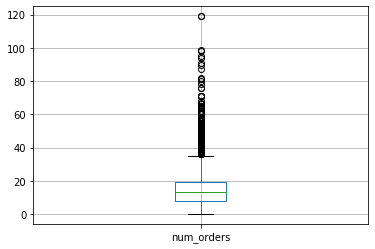

In [8]:
df.boxplot()

Есть выбросы. Проверим количество выбросов:

In [9]:
len(df.query('num_orders > 43'))

238

Всего 238 из 26 496 наблюдений (менее 1 процента). Но такие выбросы могут сильно повлиять на часовую статистику после ресемлирования.

#### - избавимся от 238 выбросов в датасете

In [10]:
df = df.query('num_orders < 44')

In [11]:
df.shape

(26258, 1)

&#9889; **Вывод:** 

1. В датасете 26 496 строк, без пропусков. 
2. Минимальное число заказов - 0, максимальное - 119, при этом 99 % всех значений не превышает 43 вызова. Среднее число вызовов - 14.
3. График "ящик с усами" выявил выбросы: всего 238 из 26 496 наблюдений (0,009%). Выявление таких значений - повод уточнить значения у поставщика данных.
4. Поскольку уточнить природу значений у поставщика данных не представляется возможным, было принято решение избавиться от 238 из 26 496 наблюдений (0,009%): данные наблюдения могут быть важными, являтся частью явления, но они не объясняются датасетом.

[Оглавление](#TOC)

## 5) Выполним ресемплирование по одному часу<a class='anchor' id='1_5'>

#### - применим сортировку к индексу, чтобы исключить нарушение порядка в индексе

In [12]:
df = df.sort_index()

#### - ресемплируем значения по одному часу

In [13]:
df = df.resample('1H', how='sum')

In [14]:
df.shape

(4416, 1)

#### - выведем первые, последние и случайные пять строк полученного датасета

In [15]:
head, tail, sample = explorer.firstsight(df)
explorer.Display('head', 'tail', 'sample')

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154


[Оглавление](#TOC)

## Вывод:<a class='anchor' id='1_conclusion'>

1. В представленном датаесете 26 496 наблюдений без пропусков: представлены данные о количестве вызовов такси (num_orders) за период от марта до сентября 2018 года (последняя дата - 31 августа 2018 года) с интервалом в 10 минут.
2. Минимальное число заказов - 0, максимальное - 119, 99 % всех значений не превышает 43 вызова. Среднее число вызовов - 14.
3. Было выявлено 238 из 26 496 (0,009%) аномальных значений, которые были удалены, чтобы избежать искажения данных при ресемплированиии: уточнить природу значений у поставщика данных не представляется возможным, а появление аномальных значений не объясняется датасетом.
4. В результате ресемплирования по одному часу был получен датасет с 4 416 наблюдениями.

[Оглавление](#TOC)

# 2. Анализ<a class='anchor' id='2'>

## 1) Построим график временного ряда<a class='anchor' id='2_1'>

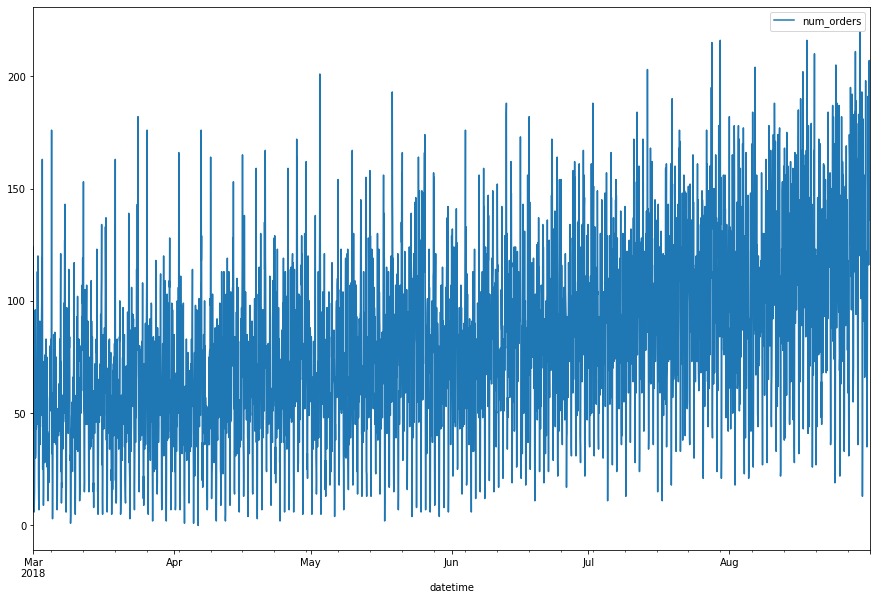

In [16]:
df.plot(figsize=(15,10))

При таком масштабе усматривается тренд к увеличению. Нужно уменьшить масштаб.

#### - ресемплиуем данные по одному дню и визуализируем результат

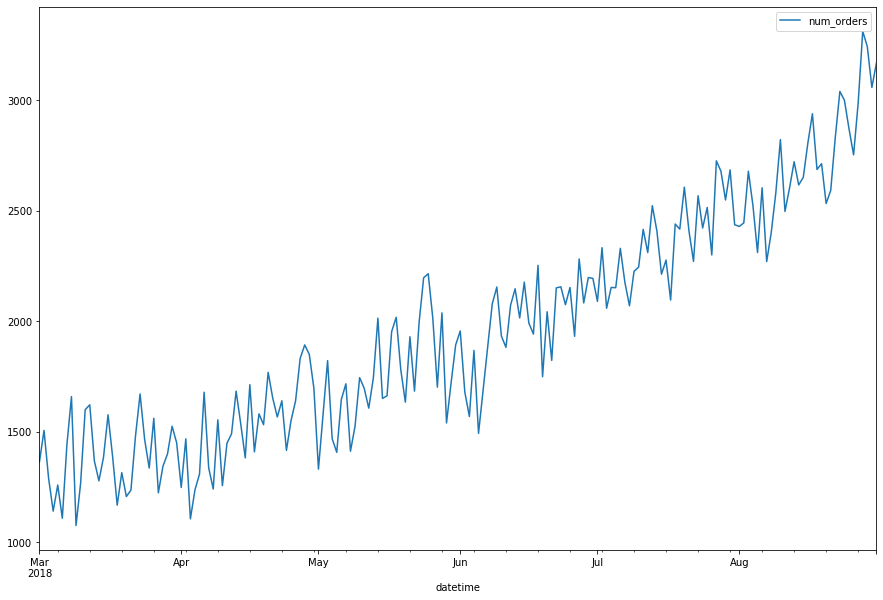

In [17]:
df.resample('1D', how='sum').plot(figsize=(15,10))

График не имеет ярких выбросов и имеет ярко выраженный тренд и, как следствие, ряд не стационарный.

#### - построим гистограмму

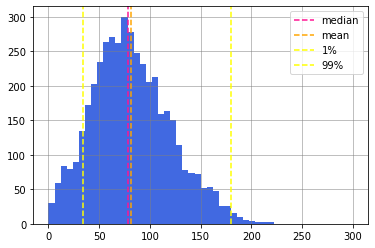

In [18]:
explorer.histogram(df.num_orders, 50, 0, 300, True)

Унимодальное распредление, незначительно скошено вправо, есть длинный хвост, но медиана и среднее почти совпадают.

[Оглавление](#TOC)

## 2) Скользящее среднее и скользящее среднее отклонение<a class='anchor' id='2_2'>

#### - вычислим и визуализируем скользящее среднее, скользящее среднее отклонение на копии датасета

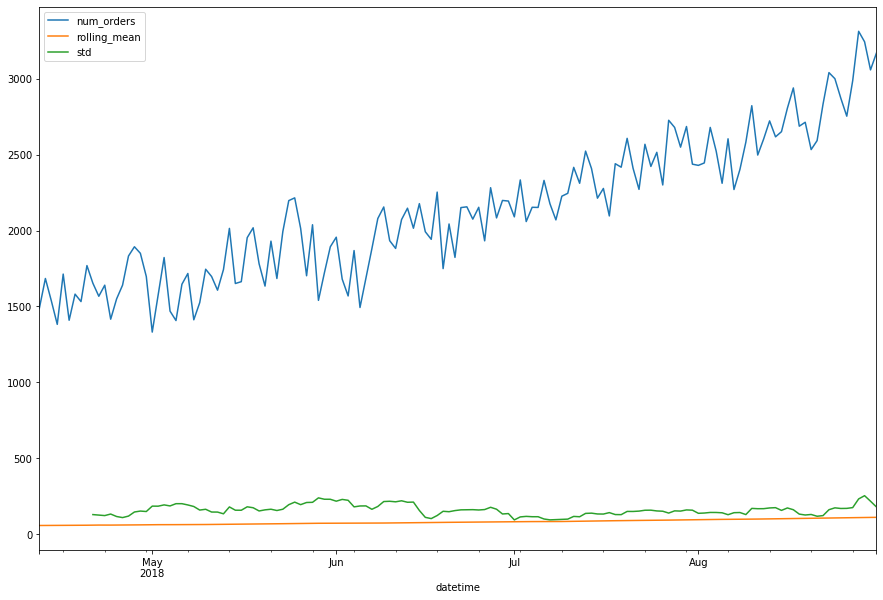

In [19]:
df_roll_mean = df.copy()
df_roll_mean = df_roll_mean.resample('1D', how='sum')
df_roll_mean['rolling_mean'] = df.rolling(1000).mean()
df_roll_mean.dropna(inplace=True)
df_roll_mean['std'] = df_roll_mean.num_orders.rolling(10).std()
df_roll_mean.plot(figsize=(15, 10))

## Вывод:<a class='anchor' id='2_conclusion'>

1. Среднее и стандартное отклонение ряда меняется, и даже при значительном сглаживании заметен тренд - ряд нестационарен.
2. Поскольку нестационарные ряды сложнее прогнозировать из-за изменичивости, а также принимая во внимание относительно короткий период наблюдений, качество предсказаний, вероятно, будет невысоким.

[Оглавление](#TOC)

# 3. Обучение<a class='anchor' id='3'>

## 1) Создадим признаки для целей обучения моделей<a class='anchor' id='3_1'>

#### - подготовим функцию для создания признаков

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

#### - применим функцию с отстающими значениями равным 24 и скользящим средним равным 24, чтобы задать общий тренд временного ряда

In [21]:
make_features(df, 24, 24)

#### - проверим, что число пропусков в строках, полученных в результате сдвига, не превышает 24 строки

In [22]:
df.isna().sum().max()

24

Придется удалить всего 24 строки из 4416 (0,005%).

#### - избавимся от строк с пропусками - 24 строки из 4416 (0,005%).

In [23]:
df.dropna(inplace=True)

In [24]:
df.shape

(4392, 29)

&#9889; **Вывод:** 

1. Были созданы признаки из остающими значениями равным 24 и скользящим средним равным 24.
2. В результате получен датасет с 24 строками с пропусками из 4416 (0,005%), а также 29 столбцами признаками, из которых 27 - отстающие значения, 1 - скользящее среднее.
3. После создания признаков и удаления 24 строк с пропусками был получен датасет в 4392 строки и 29 столбцов.

[Оглавление](#TOC)

## 2) Cоздадим словарь для поиска наилучших параметров модели, инициализируем модели, выберем параметры для подбора<a class='anchor' id='3_2'>

#### - словарь с моделями

In [25]:
models = []

#### - LinearRegression

In [26]:
lr = LinearRegression(n_jobs=-1)

param_grid={'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

models.append(('Linear Regression', lr, param_grid))

#### - RandomForestRegressor

In [27]:
rfr = RandomForestRegressor(random_state=42, n_estimators=30, max_features='auto', n_jobs=-1)

param_grid = {'max_depth': np.arange(10, 20, 2), 'min_samples_split': np.arange(2, 10, 2)}

models.append(('RandomForestRegressor', rfr, param_grid))

[Оглавление](#TOC)

#### - LGBMRegressor

In [28]:
lg = lgb.LGBMRegressor(num_leaves=600, n_estimators=300, random_state=42)

param_grid = {'n_estimators' : [150, 600],
              'num_iterations' : [300, 600],
              'learning_rate' : [0.001, 0.01]}

models.append(('LGBMRegressor', lg, param_grid))

## 3) Разделим выборку на обучающую и тестовую в соотношении 90:10, выделим целевой признак<a class='anchor' id='3_3'>

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('num_orders', axis = 1), df.num_orders, train_size=0.9, shuffle=False)

#### - целевые признаки превратим в одномерный массив

In [30]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

[Оглавление](#TOC)

# 4. Тестирование<a class='anchor' id='4'>

## 1) Объявим функцию reporter, которая соберет отчет по метрикам для каждой из моделей<a class='anchor' id='4_1'>

In [31]:
def reporter(models):
    report = []
    
    for model in models:
        print('\n', model[0], '\n')
        grid_search = explorer.grid_search(model[1], model[2], 5, 'neg_mean_squared_error', x_train, y_train)
        print(grid_search)

        predicted = np.ravel(grid_search.predict(x_test))
        rmse = mean_squared_error(y_test, predicted)**0.5
        smape = explorer.smape(y_test, predicted)
        mape = explorer.mape(y_test, predicted)

        report.append((model[0], rmse, smape, mape, grid_search))
       
    final_report = pd.DataFrame(report, columns=['model', 'rmse', 'smape', 'mape', 'grid_params'])
    
    return final_report

[Оглавление](#TOC)

## 2) Подберем наилучшие параметры для моделей, сохраним параметры и соберем метрики<a class='anchor' id='4_2'>

In [32]:
final_report = reporter(models)


 Linear Regression 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

 RandomForestRegressor 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

 LGBMRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 15.6min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_iterations=600, num_leaves=600,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


[Оглавление](#TOC)

## 3) Выведем отчет с сортировкой по значению RMSE (без параметров моделей)<a class='anchor' id='4_3'>

In [33]:
final_report[['model', 'rmse', 'smape', 'mape']].sort_values(by='rmse').style.highlight_min(color='lightgreen', axis = 0)

,model,rmse,smape,mape
0,Linear Regression,31.9138,23.2994,19.3569
2,LGBMRegressor,33.4311,24.4151,20.3632
1,RandomForestRegressor,34.1471,24.948,19.8668


[Оглавление](#TOC)

## Вывод:<a class='anchor' id='4_conclusion'>

1. Лучше всего с задачей справилась **линейная регрессия**:

    - RMSE - 31.9138,
    - SMAPE - 23.2994,
    - MAPE - 19.3569.
    
    
2. Результаты других моделей в порядке возрастания:

    - LGBMRegressor - RMSE 33.4311,
    - RandomForestRegressor - RMSE 34.1471.
    
    
3. В целом качество предсказания невысокое.
4. Итоговые результаты представлены в таблице, параметры моделей сохранены.

[Оглавление](#TOC)